In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%rm -rf ./logs/

img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'

In [2]:
def load_dataset():
    dataset = pd.read_csv(dataFolder.format('customer_behavior_labeled.csv'))
    dataset = dataset.set_index('CustomerID')
    return dataset


# How are distributed the labels?

In [3]:
dataset = load_dataset()
dataset['n of examples'] = 1
n = dataset.groupby(['Customer Type']).count()
display(n[['n of examples']])



,n of examples
Customer Type,
high-spending,772
low-spending,681
medium-spending,2271


In [4]:
dataset = load_dataset()
labels = dataset[['Customer Type']]
del dataset['Customer Type']
display(dataset)
display(labels)

,Money Spent Entropy,Mean Days btw Purchases,Mean Products In Basket,Mean Qta,Mean Money Spent
CustomerID,,,,,
12347,4.518601,167.83333,14.142857,25.217195,40.469819
12349,3.535598,697.00000,35.000000,8.800000,14.474667
12350,2.664537,697.00000,15.000000,11.714286,13.728571
12352,3.622310,85.50000,5.428571,18.666667,30.406667
12353,0.673012,697.00000,2.000000,7.000000,14.650000
...,...,...,...,...,...
18278,1.584802,697.00000,5.000000,9.333333,13.400000
18280,1.775971,697.00000,6.000000,5.200000,16.140000
18281,0.692627,697.00000,2.000000,8.000000,15.900000


,Customer Type
CustomerID,
12347,high-spending
12349,medium-spending
12350,medium-spending
12352,high-spending
12353,medium-spending
...,...
18278,medium-spending
18280,medium-spending
18281,medium-spending


In [5]:
l2 = list(set(labels['Customer Type'].unique()))
print(l2)


['medium-spending', 'high-spending', 'low-spending']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
#converted_labels = LabelEncoder().fit_transform(y_test)

# KNN

,param_model__n_neighbors,param_model__weights,param_model__algorithm,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro
rank_test_f1_macro,,,,,,
1,5,distance,ball_tree,0.896389,0.920364,0.877032
1,5,distance,brute,0.896389,0.920364,0.877032
1,5,distance,kd_tree,0.896389,0.920364,0.877032
4,5,uniform,ball_tree,0.889838,0.917353,0.868368
4,5,uniform,kd_tree,0.889838,0.917353,0.868368
4,5,uniform,brute,0.889838,0.917353,0.868368
7,20,distance,brute,0.881425,0.938648,0.843129
7,20,distance,ball_tree,0.881425,0.938648,0.843129
7,20,distance,kd_tree,0.881425,0.938648,0.843129


Train (w/o scaling)
---
F1 1.000
Precision 1.000
Recall 1.000
Test (w/o scaling)
---
F1 0.915
Precision 0.936
Recall 0.897


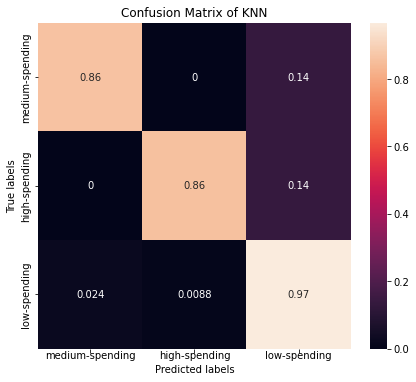

In [7]:
from sklearn.neighbors import KNeighborsClassifier

base_estimator =  Pipeline([('model', KNeighborsClassifier())])
#print("Parameters of the pipeline: ", base_estimator.get_params().keys())
param_grid = {'model__n_neighbors': [5, 20, 50],
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}


sh = GridSearchCV(base_estimator, param_grid, n_jobs=-1, cv=5, refit='f1_macro',scoring=['precision_macro', 'recall_macro', 'f1_macro']).fit(X_train, y_train)
df = pd.DataFrame(sh.cv_results_)
#print(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__n_neighbors', 'param_model__weights','param_model__algorithm','mean_test_f1_macro']].set_index('rank_test_f1_macro')[:3].to_latex())
display(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__n_neighbors', 'param_model__weights','param_model__algorithm','mean_test_f1_macro', 'mean_test_precision_macro', 'mean_test_recall_macro']].set_index('rank_test_f1_macro'))

y_pred = sh.best_estimator_.predict(X_train)
print("Train (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_train, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_train, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_train, y_pred, average='macro')))

y_pred = sh.best_estimator_.predict(X_test)
print("Test (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_test, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_test, y_pred, average='macro')))

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of KNN'); 
ax.xaxis.set_ticklabels(l2, va='center'); ax.yaxis.set_ticklabels(l2,va='center');
plt.savefig(img.format("KNN_without_scaler"))
plt.show()


## KNN with StandardScaler

,param_model__n_neighbors,param_model__weights,param_model__algorithm,mean_test_f1_macro
rank_test_f1_macro,,,,
1,5,distance,ball_tree,0.919045
1,5,distance,brute,0.919045
1,5,distance,kd_tree,0.919045
4,5,uniform,ball_tree,0.912208
4,5,uniform,kd_tree,0.912208
4,5,uniform,brute,0.912208
7,20,distance,brute,0.906239
7,20,distance,ball_tree,0.906239
7,20,distance,kd_tree,0.906239


Train (w/o scaling)
---
F1 1.000
Precision 1.000
Recall 1.000
Test (w/o scaling)
---
F1 0.929
Precision 0.945
Recall 0.916


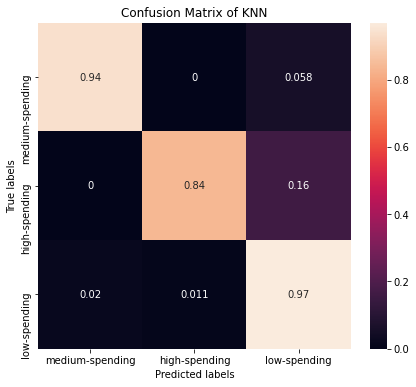

In [8]:
from sklearn.neighbors import KNeighborsClassifier

base_estimator =  Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())])
#print("Parameters of the pipeline: ", base_estimator.get_params().keys())
param_grid = {'model__n_neighbors': [5, 20, 50],
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}


sh = GridSearchCV(base_estimator, param_grid, n_jobs=-1, cv=5, refit='f1_macro',scoring=['precision_macro', 'recall_macro', 'f1_macro']).fit(X_train, y_train)
df = pd.DataFrame(sh.cv_results_)
#print(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__n_neighbors', 'param_model__weights','param_model__algorithm','mean_test_f1_macro']].set_index('rank_test_f1_macro')[:3].to_latex())

display(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__n_neighbors', 'param_model__weights','param_model__algorithm','mean_test_f1_macro']].set_index('rank_test_f1_macro'))

y_pred = sh.best_estimator_.predict(X_train)
print("Train (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_train, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_train, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_train, y_pred, average='macro')))

y_pred = sh.best_estimator_.predict(X_test)
print("Test (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_test, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_test, y_pred, average='macro')))

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of KNN'); 
ax.xaxis.set_ticklabels(l2); ax.yaxis.set_ticklabels(l2);
plt.savefig(img.format("KNN_with_scaler"))
plt.show()


So, we can observe that with standardized data we have better results.

# SVC

,param_model__C,param_model__class_weight,param_model__gamma,param_model__kernel,mean_test_f1_macro
rank_test_f1_macro,,,,,
1,0.01,balanced,auto,linear,0.859040
2,0.1,balanced,auto,linear,0.858274
3,0.5,balanced,auto,linear,0.856166
4,1,balanced,auto,linear,0.855451
5,0.001,balanced,auto,linear,0.838649
6,0.5,None,auto,linear,0.814447
7,0.1,None,auto,linear,0.814298
8,1,None,auto,linear,0.811425
9,0.01,None,auto,linear,0.805397


Train (w/o scaling)
---
F1 0.860
Precision 0.834
Recall 0.914
Test (w/o scaling)
---
F1 0.839
Precision 0.815
Recall 0.893


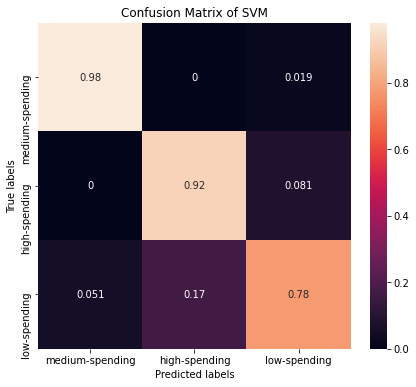

In [9]:
base_estimator =  Pipeline([('model', SVC())])
#print("Parameters of the pipeline: ", base_estimator.get_params().keys())
param_grid = {'model__C': [1, 0.5, 0.1, 0.01, 0.001],
 'model__gamma': ['auto'],
 'model__kernel': ['linear','rbf'],
 'model__class_weight':['balanced', None]}


sh = GridSearchCV(base_estimator, param_grid, n_jobs=-1, cv=5, refit='f1_macro',scoring=['precision_macro', 'recall_macro', 'f1_macro']).fit(X_train, y_train)
df = pd.DataFrame(sh.cv_results_)
display(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__C', 'param_model__class_weight','param_model__gamma','param_model__kernel','mean_test_f1_macro']].set_index('rank_test_f1_macro'))

#print(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__C', 'param_model__class_weight','param_model__gamma','param_model__kernel','mean_test_f1_macro']].set_index('rank_test_f1_macro')[:1].to_latex())

y_pred = sh.best_estimator_.predict(X_train)
print("Train (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_train, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_train, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_train, y_pred, average='macro')))

y_pred = sh.best_estimator_.predict(X_test)
print("Test (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_test, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_test, y_pred, average='macro')))

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of SVM'); 
ax.xaxis.set_ticklabels(l2); ax.yaxis.set_ticklabels(l2);
plt.savefig(img.format("SVM_without_scaler"))
plt.show()


## SVC with StandardScaler

,param_model__C,param_model__class_weight,param_model__gamma,param_model__kernel,mean_test_f1_macro
rank_test_f1_macro,,,,,
1,1,None,auto,rbf,0.920523
2,1,balanced,auto,rbf,0.914059
3,0.5,balanced,auto,rbf,0.902899
4,0.5,None,auto,rbf,0.896427
5,1,balanced,auto,linear,0.854608
6,0.5,balanced,auto,linear,0.852561
7,0.1,balanced,auto,linear,0.832219
8,0.1,balanced,auto,rbf,0.810207
9,1,None,auto,linear,0.807789


Train (w/o scaling)
---
F1 0.930
Precision 0.955
Recall 0.909
Test (w/o scaling)
---
F1 0.916
Precision 0.949
Recall 0.892


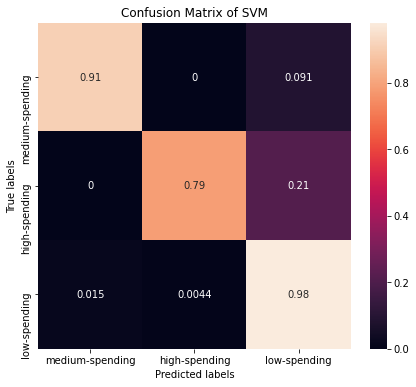

In [10]:
base_estimator =  Pipeline([('scaler', StandardScaler()), ('model', SVC())])

#print("Parameters of the pipeline: ", base_estimator.get_params().keys())
param_grid = {'model__C': [1, 0.5, 0.1, 0.01, 0.001],
 'model__gamma': ['auto'],
 'model__kernel': ['linear','rbf'],
 'model__class_weight':['balanced', None]}


sh = GridSearchCV(base_estimator, param_grid, n_jobs=-1, cv=5, refit='f1_macro',scoring=['precision_macro', 'recall_macro', 'f1_macro']).fit(X_train, y_train)
df = pd.DataFrame(sh.cv_results_)
display(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__C', 'param_model__class_weight','param_model__gamma','param_model__kernel','mean_test_f1_macro']].set_index('rank_test_f1_macro'))

#print(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__C', 'param_model__class_weight','param_model__gamma','param_model__kernel','mean_test_f1_macro']].set_index('rank_test_f1_macro')[:1].to_latex())

y_pred = sh.best_estimator_.predict(X_train)
print("Train (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_train, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_train, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_train, y_pred, average='macro')))

y_pred = sh.best_estimator_.predict(X_test)
print("Test (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_test, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_test, y_pred, average='macro')))

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of SVM'); 
ax.xaxis.set_ticklabels(l2); ax.yaxis.set_ticklabels(l2);
plt.savefig(img.format("SVM_with_scaler"))
plt.show()


## Decision Tree

Train (w/o scaling)
---
F1 0.930
Precision 0.955
Recall 0.909
Test 
---
F1 1.000
Precision 1.000
Recall 1.000


<Figure size 1440x1440 with 0 Axes>

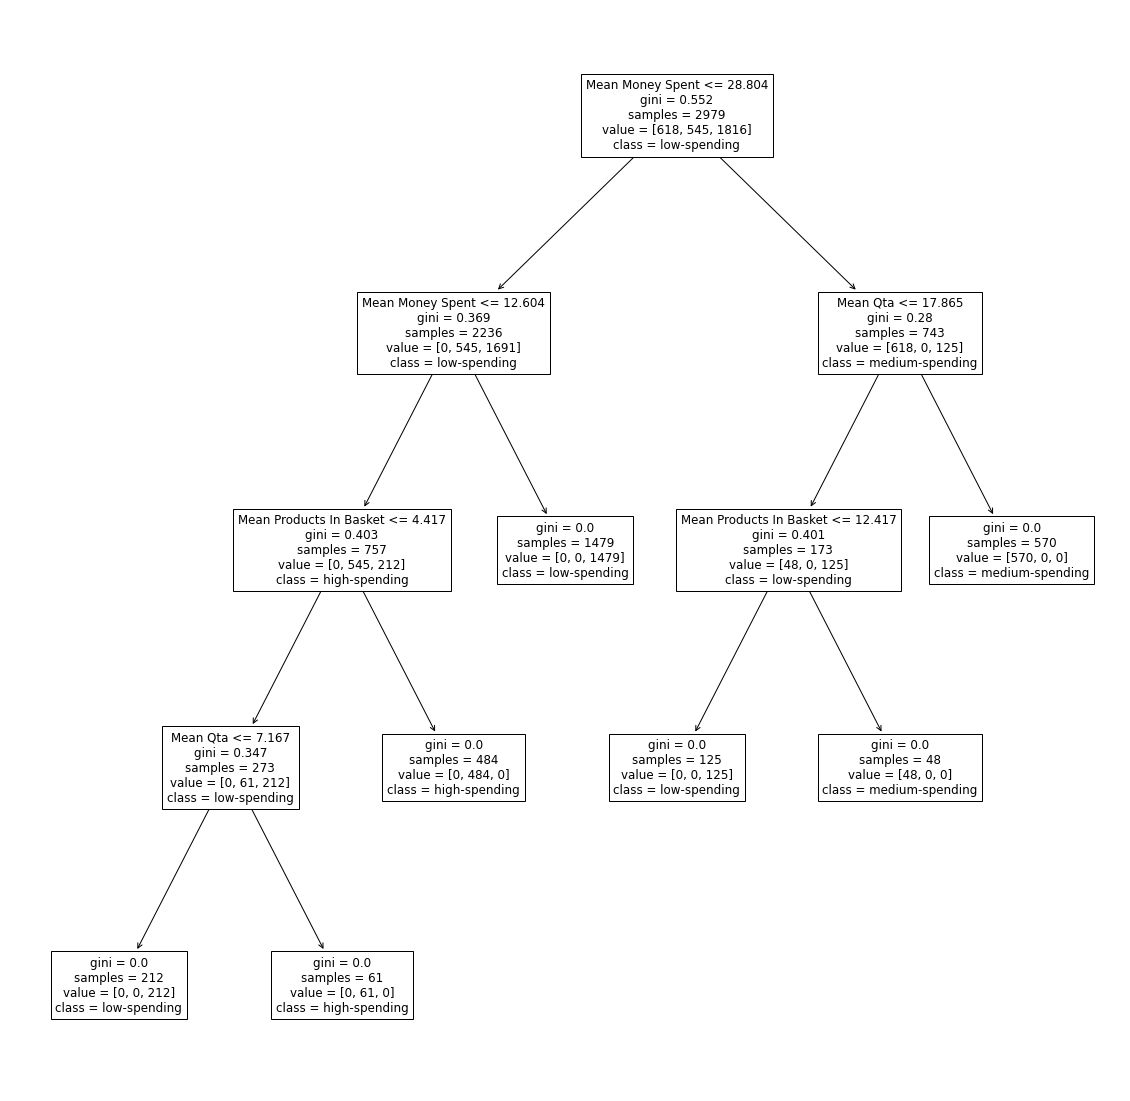

True

In [11]:
import pydotplus
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
base_estimator =  Pipeline([('model', DecisionTreeClassifier())])
y_pred = sh.best_estimator_.predict(X_train)
print("Train (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_train, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_train, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_train, y_pred, average='macro')))


y_pred = base_estimator.fit(X_train,y_train).predict(X_test)

print("Test \n---")
print("F1 {:.3f}".format(f1_score(y_test, y_pred,labels=l2, average='macro')))
print("Precision {:.3f}".format(precision_score(y_test, y_pred,labels=l2, average='macro')))
print("Recall {:.3f}".format(recall_score(y_test, y_pred,labels=l2, average='macro')))

plt.figure(figsize=(20,20))

plt.figure(figsize=(20,20))
plot_tree(base_estimator['model'],feature_names=dataset.columns, class_names=l2,)
plt.show()

dot_data = export_graphviz(base_estimator['model'], out_file=None, 
                           class_names=l2,
                         feature_names=dataset.columns,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png(img.format('decision_tree'))


,param_model__max_depth,param_model__max_features,param_model__min_samples_split,param_model__min_samples_leaf,param_model__bootstrap,param_model__n_estimators,param_model__criterion,param_model__class_weight,mean_test_f1_macro
rank_test_f1_macro,,,,,,,,,
1,None,auto,2,4,False,100,gini,None,0.999242
2,50,auto,10,2,False,100,gini,None,0.999205
2,10,auto,5,4,False,100,gini,None,0.999205
2,50,auto,10,2,False,200,gini,None,0.999205
2,20,auto,2,2,False,100,entropy,None,0.999205
...,...,...,...,...,...,...,...,...,...
568,50,auto,10,2,True,100,gini,balanced,0.995965
573,None,auto,10,4,True,100,gini,balanced,0.995924
574,50,auto,10,4,True,100,gini,balanced,0.995611


Train (w/o scaling)
---
F1 1.000
Precision 1.000
Recall 1.000
Test (w/o scaling)
---
F1 1.000
Precision 1.000
Recall 1.000


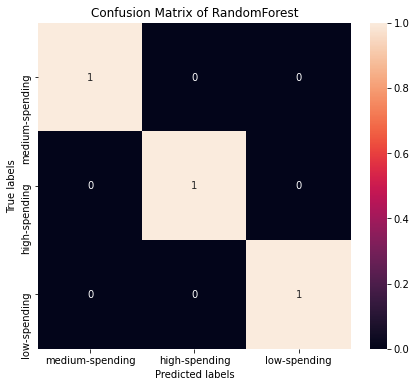

In [12]:
from sklearn.ensemble import RandomForestClassifier

base_estimator =  Pipeline([('model', RandomForestClassifier())])
#print("Parameters of the pipeline: ", base_estimator.get_params().keys())
param_grid = {'model__max_depth': [10, 20, 50, None],
              'model__max_features': ['auto'],
              'model__min_samples_split': [2, 5, 10],
              'model__min_samples_leaf': [1, 2, 4],
              'model__bootstrap': [True, False],
              'model__n_estimators': [100, 200],
              'model__criterion': ["entropy", "gini"],
              'model__class_weight':['balanced', None]}

sh = GridSearchCV(base_estimator, param_grid, n_jobs=-1, cv=5, refit='f1_macro',scoring=['precision_macro', 'recall_macro', 'f1_macro']).fit(X_train, y_train)
df = pd.DataFrame(sh.cv_results_)
display(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','param_model__max_depth','param_model__max_features','param_model__min_samples_split','param_model__min_samples_leaf','param_model__bootstrap','param_model__n_estimators','param_model__criterion','param_model__class_weight','mean_test_f1_macro']].set_index('rank_test_f1_macro'))
#print(df.sort_values(by='rank_test_f1_macro')[['rank_test_f1_macro','model__max_depth','model__max_features','model__min_samples_split','model__min_samples_leaf','model__bootstrap','model__estimators','model__criterion','model__class_weight','mean_test_f1_macro']].set_index('rank_test_f1_macro'))[:1].to_latex())
y_pred = sh.best_estimator_.predict(X_train)
print("Train (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_train, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_train, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_train, y_pred, average='macro')))

y_pred = sh.best_estimator_.predict(X_test)
print("Test (w/o scaling)\n---")
print("F1 {:.3f}".format(f1_score(y_test, y_pred, average='macro')))
print("Precision {:.3f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall {:.3f}".format(recall_score(y_test, y_pred, average='macro')))

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of RandomForest'); 
ax.xaxis.set_ticklabels(l2); ax.yaxis.set_ticklabels(l2);
plt.savefig(img.format("RandomForest"))
plt.show()
